In [67]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report, roc_auc_score,mean_squared_error
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
# import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [68]:
# 删除相关性小的特征
data = pd.read_pickle('./data.pickle')
select_features = ['user_id','cp_server_no','cp_role_id','role_created_3_login_num',
       'role_created_3_active', 'role_created_3_online',
       'role_created_3_max_role_level', 'role_created_3_ip_num',
       'role_created_3_pay_num', 'role_created_3_pay_sum', 'active_0-8', 'active_8-12', 'active_12-14',
       'active_14-18', 'active_18-24', 'pay_grade_1', 'pay_grade_2',
       'pay_grade_3', 'pay_grade_4', 'pay_grade_5', 'pay_grade_6',
       'role_created_3_pay_rate', 'role_created_3_pay_avg']
label = ['role_created_30_pay_sum']
df = data[select_features].join(data[label])
df['role_created_30_pay_sum'].fillna(0,inplace=True)

In [72]:
df_train, df_test = train_test_split(df,test_size=0.3)
df_train_3_pay = df_train[df_train['role_created_3_pay_sum']>0]
df_train_3_nopay = df_train[df_train['role_created_3_pay_sum']==0]
df_train_3_nopay_online_n = df_train_3_nopay[(df_train_3_nopay['role_created_3_online']==907) | (df_train_3_nopay['role_created_3_login_num']<3)|(df_train_3_nopay['role_created_3_max_role_level']==1)]
df_train_3_nopay_online_y = df_train_3_nopay.loc[np.setdiff1d(df_train_3_nopay.index, df_train_3_nopay_online_n.index),:]

In [83]:
target = df_train_3_pay['role_created_30_pay_sum']
target_ln = np.log1p(target)
features = df_train_3_pay.drop(['role_created_30_pay_sum','user_id','cp_server_no','cp_role_id'], axis=1)

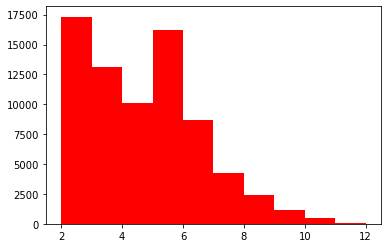

In [84]:
# 将target进行log1p转换，更符合正态分布
plt.hist(target_ln, color='red', range=(2, 12))
plt.show()

In [88]:
X_val, x_test, Y_val, y_test = train_test_split(features,target_ln, test_size=0.3)
params = {

'boosting_type':'gbdt',
'objective':'regression',
'metric':'rmse',
'nthread':4,
'learning_rate':0.001,
"max_depth":5,
"num_leaves":20,
"max_bin":255,
"min_data_in_leaf":61,
"min_split_gain":1.0,
"feature_fraction": 1.0,
"bagging_fraction":1.0,
"bagging_freq":45,
"lambda_l1":1,
"lambda_l2":0.4,
"metric": "rmse",
}
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])


[1]	training's rmse: 1.81212	valid_1's rmse: 1.79745
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.81083	valid_1's rmse: 1.79617
[3]	training's rmse: 1.80953	valid_1's rmse: 1.79488
[4]	training's rmse: 1.80824	valid_1's rmse: 1.79359
[5]	training's rmse: 1.80695	valid_1's rmse: 1.79231
[6]	training's rmse: 1.80566	valid_1's rmse: 1.79103
[7]	training's rmse: 1.80437	valid_1's rmse: 1.78975
[8]	training's rmse: 1.80309	valid_1's rmse: 1.78847
[9]	training's rmse: 1.8018	valid_1's rmse: 1.78719
[10]	training's rmse: 1.80052	valid_1's rmse: 1.78591
[11]	training's rmse: 1.79924	valid_1's rmse: 1.78464
[12]	training's rmse: 1.79796	valid_1's rmse: 1.78337
[13]	training's rmse: 1.79668	valid_1's rmse: 1.7821
[14]	training's rmse: 1.7954	valid_1's rmse: 1.78083
[15]	training's rmse: 1.79413	valid_1's rmse: 1.77956
[16]	training's rmse: 1.79286	valid_1's rmse: 1.77829
[17]	training's rmse: 1.79159	valid_1's rmse: 1.77703
[18]	training's rmse: 1.79032	va

[221]	training's rmse: 1.56404	valid_1's rmse: 1.55083
[222]	training's rmse: 1.56307	valid_1's rmse: 1.54987
[223]	training's rmse: 1.5621	valid_1's rmse: 1.54891
[224]	training's rmse: 1.56113	valid_1's rmse: 1.54794
[225]	training's rmse: 1.56016	valid_1's rmse: 1.54699
[226]	training's rmse: 1.5592	valid_1's rmse: 1.54603
[227]	training's rmse: 1.55824	valid_1's rmse: 1.54507
[228]	training's rmse: 1.55727	valid_1's rmse: 1.54412
[229]	training's rmse: 1.55631	valid_1's rmse: 1.54316
[230]	training's rmse: 1.55535	valid_1's rmse: 1.54221
[231]	training's rmse: 1.5544	valid_1's rmse: 1.54126
[232]	training's rmse: 1.55344	valid_1's rmse: 1.54031
[233]	training's rmse: 1.55248	valid_1's rmse: 1.53936
[234]	training's rmse: 1.55153	valid_1's rmse: 1.53841
[235]	training's rmse: 1.55058	valid_1's rmse: 1.53747
[236]	training's rmse: 1.54963	valid_1's rmse: 1.53652
[237]	training's rmse: 1.54868	valid_1's rmse: 1.53558
[238]	training's rmse: 1.54773	valid_1's rmse: 1.53464
[239]	trainin

[371]	training's rmse: 1.43252	valid_1's rmse: 1.4204
[372]	training's rmse: 1.43173	valid_1's rmse: 1.41962
[373]	training's rmse: 1.43095	valid_1's rmse: 1.41884
[374]	training's rmse: 1.43016	valid_1's rmse: 1.41806
[375]	training's rmse: 1.42938	valid_1's rmse: 1.41729
[376]	training's rmse: 1.4286	valid_1's rmse: 1.41651
[377]	training's rmse: 1.42782	valid_1's rmse: 1.41574
[378]	training's rmse: 1.42704	valid_1's rmse: 1.41496
[379]	training's rmse: 1.42626	valid_1's rmse: 1.41419
[380]	training's rmse: 1.42548	valid_1's rmse: 1.41342
[381]	training's rmse: 1.4247	valid_1's rmse: 1.41265
[382]	training's rmse: 1.42393	valid_1's rmse: 1.41188
[383]	training's rmse: 1.42315	valid_1's rmse: 1.41112
[384]	training's rmse: 1.42238	valid_1's rmse: 1.41035
[385]	training's rmse: 1.42161	valid_1's rmse: 1.40959
[386]	training's rmse: 1.42083	valid_1's rmse: 1.40882
[387]	training's rmse: 1.42006	valid_1's rmse: 1.40806
[388]	training's rmse: 1.4193	valid_1's rmse: 1.4073
[389]	training'

[526]	training's rmse: 1.3232	valid_1's rmse: 1.31219
[527]	training's rmse: 1.32258	valid_1's rmse: 1.31157
[528]	training's rmse: 1.32195	valid_1's rmse: 1.31095
[529]	training's rmse: 1.32132	valid_1's rmse: 1.31033
[530]	training's rmse: 1.3207	valid_1's rmse: 1.30971
[531]	training's rmse: 1.32007	valid_1's rmse: 1.3091
[532]	training's rmse: 1.31945	valid_1's rmse: 1.30848
[533]	training's rmse: 1.31883	valid_1's rmse: 1.30787
[534]	training's rmse: 1.31821	valid_1's rmse: 1.30725
[535]	training's rmse: 1.31759	valid_1's rmse: 1.30664
[536]	training's rmse: 1.31697	valid_1's rmse: 1.30603
[537]	training's rmse: 1.31635	valid_1's rmse: 1.30542
[538]	training's rmse: 1.31574	valid_1's rmse: 1.30481
[539]	training's rmse: 1.31512	valid_1's rmse: 1.3042
[540]	training's rmse: 1.3145	valid_1's rmse: 1.30359
[541]	training's rmse: 1.31389	valid_1's rmse: 1.30298
[542]	training's rmse: 1.31328	valid_1's rmse: 1.30238
[543]	training's rmse: 1.31266	valid_1's rmse: 1.30177
[544]	training'

[685]	training's rmse: 1.23452	valid_1's rmse: 1.22464
[686]	training's rmse: 1.23402	valid_1's rmse: 1.22416
[687]	training's rmse: 1.23353	valid_1's rmse: 1.22367
[688]	training's rmse: 1.23304	valid_1's rmse: 1.22319
[689]	training's rmse: 1.23255	valid_1's rmse: 1.22271
[690]	training's rmse: 1.23206	valid_1's rmse: 1.22223
[691]	training's rmse: 1.23158	valid_1's rmse: 1.22175
[692]	training's rmse: 1.23109	valid_1's rmse: 1.22127
[693]	training's rmse: 1.2306	valid_1's rmse: 1.22079
[694]	training's rmse: 1.23012	valid_1's rmse: 1.22031
[695]	training's rmse: 1.22963	valid_1's rmse: 1.21983
[696]	training's rmse: 1.22915	valid_1's rmse: 1.21935
[697]	training's rmse: 1.22866	valid_1's rmse: 1.21888
[698]	training's rmse: 1.22818	valid_1's rmse: 1.2184
[699]	training's rmse: 1.2277	valid_1's rmse: 1.21793
[700]	training's rmse: 1.22722	valid_1's rmse: 1.21746
[701]	training's rmse: 1.22674	valid_1's rmse: 1.21698
[702]	training's rmse: 1.22626	valid_1's rmse: 1.21651
[703]	trainin

[846]	training's rmse: 1.16456	valid_1's rmse: 1.15587
[847]	training's rmse: 1.16417	valid_1's rmse: 1.1555
[848]	training's rmse: 1.1638	valid_1's rmse: 1.15512
[849]	training's rmse: 1.16342	valid_1's rmse: 1.15475
[850]	training's rmse: 1.16304	valid_1's rmse: 1.15438
[851]	training's rmse: 1.16266	valid_1's rmse: 1.15401
[852]	training's rmse: 1.16228	valid_1's rmse: 1.15364
[853]	training's rmse: 1.16191	valid_1's rmse: 1.15327
[854]	training's rmse: 1.16153	valid_1's rmse: 1.1529
[855]	training's rmse: 1.16115	valid_1's rmse: 1.15253
[856]	training's rmse: 1.16078	valid_1's rmse: 1.15216
[857]	training's rmse: 1.16041	valid_1's rmse: 1.1518
[858]	training's rmse: 1.16003	valid_1's rmse: 1.15143
[859]	training's rmse: 1.15966	valid_1's rmse: 1.15106
[860]	training's rmse: 1.15929	valid_1's rmse: 1.1507
[861]	training's rmse: 1.15891	valid_1's rmse: 1.15033
[862]	training's rmse: 1.15854	valid_1's rmse: 1.14997
[863]	training's rmse: 1.15817	valid_1's rmse: 1.14961
[864]	training'

[1011]	training's rmse: 1.10957	valid_1's rmse: 1.10202
[1012]	training's rmse: 1.10928	valid_1's rmse: 1.10173
[1013]	training's rmse: 1.109	valid_1's rmse: 1.10145
[1014]	training's rmse: 1.10871	valid_1's rmse: 1.10117
[1015]	training's rmse: 1.10842	valid_1's rmse: 1.10089
[1016]	training's rmse: 1.10813	valid_1's rmse: 1.10061
[1017]	training's rmse: 1.10785	valid_1's rmse: 1.10033
[1018]	training's rmse: 1.10756	valid_1's rmse: 1.10005
[1019]	training's rmse: 1.10728	valid_1's rmse: 1.09977
[1020]	training's rmse: 1.10699	valid_1's rmse: 1.09949
[1021]	training's rmse: 1.10671	valid_1's rmse: 1.09921
[1022]	training's rmse: 1.10642	valid_1's rmse: 1.09893
[1023]	training's rmse: 1.10614	valid_1's rmse: 1.09865
[1024]	training's rmse: 1.10585	valid_1's rmse: 1.09838
[1025]	training's rmse: 1.10557	valid_1's rmse: 1.0981
[1026]	training's rmse: 1.10529	valid_1's rmse: 1.09782
[1027]	training's rmse: 1.10501	valid_1's rmse: 1.09755
[1028]	training's rmse: 1.10473	valid_1's rmse: 1.0

[1176]	training's rmse: 1.06797	valid_1's rmse: 1.06144
[1177]	training's rmse: 1.06775	valid_1's rmse: 1.06123
[1178]	training's rmse: 1.06753	valid_1's rmse: 1.06102
[1179]	training's rmse: 1.06732	valid_1's rmse: 1.06081
[1180]	training's rmse: 1.0671	valid_1's rmse: 1.0606
[1181]	training's rmse: 1.06688	valid_1's rmse: 1.06039
[1182]	training's rmse: 1.06667	valid_1's rmse: 1.06018
[1183]	training's rmse: 1.06645	valid_1's rmse: 1.05997
[1184]	training's rmse: 1.06624	valid_1's rmse: 1.05976
[1185]	training's rmse: 1.06602	valid_1's rmse: 1.05955
[1186]	training's rmse: 1.06581	valid_1's rmse: 1.05934
[1187]	training's rmse: 1.06559	valid_1's rmse: 1.05913
[1188]	training's rmse: 1.06538	valid_1's rmse: 1.05892
[1189]	training's rmse: 1.06516	valid_1's rmse: 1.05872
[1190]	training's rmse: 1.06495	valid_1's rmse: 1.05851
[1191]	training's rmse: 1.06474	valid_1's rmse: 1.0583
[1192]	training's rmse: 1.06453	valid_1's rmse: 1.05809
[1193]	training's rmse: 1.06431	valid_1's rmse: 1.0

[1342]	training's rmse: 1.03648	valid_1's rmse: 1.03089
[1343]	training's rmse: 1.03632	valid_1's rmse: 1.03073
[1344]	training's rmse: 1.03615	valid_1's rmse: 1.03058
[1345]	training's rmse: 1.03599	valid_1's rmse: 1.03042
[1346]	training's rmse: 1.03583	valid_1's rmse: 1.03026
[1347]	training's rmse: 1.03566	valid_1's rmse: 1.03011
[1348]	training's rmse: 1.0355	valid_1's rmse: 1.02995
[1349]	training's rmse: 1.03534	valid_1's rmse: 1.02979
[1350]	training's rmse: 1.03518	valid_1's rmse: 1.02964
[1351]	training's rmse: 1.03502	valid_1's rmse: 1.02948
[1352]	training's rmse: 1.03486	valid_1's rmse: 1.02933
[1353]	training's rmse: 1.0347	valid_1's rmse: 1.02917
[1354]	training's rmse: 1.03454	valid_1's rmse: 1.02902
[1355]	training's rmse: 1.03438	valid_1's rmse: 1.02886
[1356]	training's rmse: 1.03422	valid_1's rmse: 1.02871
[1357]	training's rmse: 1.03406	valid_1's rmse: 1.02856
[1358]	training's rmse: 1.0339	valid_1's rmse: 1.0284
[1359]	training's rmse: 1.03374	valid_1's rmse: 1.02

[1510]	training's rmse: 1.01271	valid_1's rmse: 1.00801
[1511]	training's rmse: 1.01259	valid_1's rmse: 1.00789
[1512]	training's rmse: 1.01247	valid_1's rmse: 1.00778
[1513]	training's rmse: 1.01235	valid_1's rmse: 1.00766
[1514]	training's rmse: 1.01223	valid_1's rmse: 1.00755
[1515]	training's rmse: 1.01211	valid_1's rmse: 1.00743
[1516]	training's rmse: 1.01199	valid_1's rmse: 1.00732
[1517]	training's rmse: 1.01187	valid_1's rmse: 1.0072
[1518]	training's rmse: 1.01175	valid_1's rmse: 1.00709
[1519]	training's rmse: 1.01163	valid_1's rmse: 1.00697
[1520]	training's rmse: 1.01151	valid_1's rmse: 1.00686
[1521]	training's rmse: 1.01139	valid_1's rmse: 1.00675
[1522]	training's rmse: 1.01127	valid_1's rmse: 1.00663
[1523]	training's rmse: 1.01115	valid_1's rmse: 1.00652
[1524]	training's rmse: 1.01103	valid_1's rmse: 1.00641
[1525]	training's rmse: 1.01092	valid_1's rmse: 1.00629
[1526]	training's rmse: 1.0108	valid_1's rmse: 1.00618
[1527]	training's rmse: 1.01068	valid_1's rmse: 1.

[1677]	training's rmse: 0.995203	valid_1's rmse: 0.991356
[1678]	training's rmse: 0.995114	valid_1's rmse: 0.991272
[1679]	training's rmse: 0.995024	valid_1's rmse: 0.991187
[1680]	training's rmse: 0.994934	valid_1's rmse: 0.991103
[1681]	training's rmse: 0.994845	valid_1's rmse: 0.991019
[1682]	training's rmse: 0.994756	valid_1's rmse: 0.990935
[1683]	training's rmse: 0.994667	valid_1's rmse: 0.990852
[1684]	training's rmse: 0.994578	valid_1's rmse: 0.990767
[1685]	training's rmse: 0.994489	valid_1's rmse: 0.990683
[1686]	training's rmse: 0.994401	valid_1's rmse: 0.990599
[1687]	training's rmse: 0.994312	valid_1's rmse: 0.990516
[1688]	training's rmse: 0.994224	valid_1's rmse: 0.990434
[1689]	training's rmse: 0.994136	valid_1's rmse: 0.990351
[1690]	training's rmse: 0.994049	valid_1's rmse: 0.990268
[1691]	training's rmse: 0.99396	valid_1's rmse: 0.990185
[1692]	training's rmse: 0.993873	valid_1's rmse: 0.990103
[1693]	training's rmse: 0.993785	valid_1's rmse: 0.99002
[1694]	training'

[1847]	training's rmse: 0.982032	valid_1's rmse: 0.979007
[1848]	training's rmse: 0.981967	valid_1's rmse: 0.978946
[1849]	training's rmse: 0.9819	valid_1's rmse: 0.978883
[1850]	training's rmse: 0.981834	valid_1's rmse: 0.978823
[1851]	training's rmse: 0.981768	valid_1's rmse: 0.978762
[1852]	training's rmse: 0.981703	valid_1's rmse: 0.9787
[1853]	training's rmse: 0.981637	valid_1's rmse: 0.978639
[1854]	training's rmse: 0.981572	valid_1's rmse: 0.978578
[1855]	training's rmse: 0.981506	valid_1's rmse: 0.978518
[1856]	training's rmse: 0.981441	valid_1's rmse: 0.978458
[1857]	training's rmse: 0.981376	valid_1's rmse: 0.978396
[1858]	training's rmse: 0.981311	valid_1's rmse: 0.978336
[1859]	training's rmse: 0.981246	valid_1's rmse: 0.978275
[1860]	training's rmse: 0.981182	valid_1's rmse: 0.978215
[1861]	training's rmse: 0.981117	valid_1's rmse: 0.978154
[1862]	training's rmse: 0.981052	valid_1's rmse: 0.978095
[1863]	training's rmse: 0.980988	valid_1's rmse: 0.978035
[1864]	training's 

[2019]	training's rmse: 0.972236	valid_1's rmse: 0.969966
[2020]	training's rmse: 0.972187	valid_1's rmse: 0.969921
[2021]	training's rmse: 0.972139	valid_1's rmse: 0.969877
[2022]	training's rmse: 0.972091	valid_1's rmse: 0.969833
[2023]	training's rmse: 0.972042	valid_1's rmse: 0.969789
[2024]	training's rmse: 0.971994	valid_1's rmse: 0.969746
[2025]	training's rmse: 0.971946	valid_1's rmse: 0.969702
[2026]	training's rmse: 0.971898	valid_1's rmse: 0.969658
[2027]	training's rmse: 0.97185	valid_1's rmse: 0.969615
[2028]	training's rmse: 0.971802	valid_1's rmse: 0.969571
[2029]	training's rmse: 0.971754	valid_1's rmse: 0.969527
[2030]	training's rmse: 0.971706	valid_1's rmse: 0.969484
[2031]	training's rmse: 0.971659	valid_1's rmse: 0.969441
[2032]	training's rmse: 0.971611	valid_1's rmse: 0.969398
[2033]	training's rmse: 0.971563	valid_1's rmse: 0.969355
[2034]	training's rmse: 0.971516	valid_1's rmse: 0.969311
[2035]	training's rmse: 0.971468	valid_1's rmse: 0.969267
[2036]	training

[2187]	training's rmse: 0.965145	valid_1's rmse: 0.963585
[2188]	training's rmse: 0.965109	valid_1's rmse: 0.963552
[2189]	training's rmse: 0.965073	valid_1's rmse: 0.963519
[2190]	training's rmse: 0.965037	valid_1's rmse: 0.963486
[2191]	training's rmse: 0.965001	valid_1's rmse: 0.963455
[2192]	training's rmse: 0.964965	valid_1's rmse: 0.963423
[2193]	training's rmse: 0.964929	valid_1's rmse: 0.963391
[2194]	training's rmse: 0.964892	valid_1's rmse: 0.963358
[2195]	training's rmse: 0.964857	valid_1's rmse: 0.963326
[2196]	training's rmse: 0.964821	valid_1's rmse: 0.963295
[2197]	training's rmse: 0.964785	valid_1's rmse: 0.963264
[2198]	training's rmse: 0.96475	valid_1's rmse: 0.963233
[2199]	training's rmse: 0.964714	valid_1's rmse: 0.9632
[2200]	training's rmse: 0.964678	valid_1's rmse: 0.963169
[2201]	training's rmse: 0.964643	valid_1's rmse: 0.963137
[2202]	training's rmse: 0.964607	valid_1's rmse: 0.963105
[2203]	training's rmse: 0.964572	valid_1's rmse: 0.963074
[2204]	training's

[2353]	training's rmse: 0.959873	valid_1's rmse: 0.958936
[2354]	training's rmse: 0.959846	valid_1's rmse: 0.958912
[2355]	training's rmse: 0.959818	valid_1's rmse: 0.958888
[2356]	training's rmse: 0.959791	valid_1's rmse: 0.958864
[2357]	training's rmse: 0.959764	valid_1's rmse: 0.958841
[2358]	training's rmse: 0.959736	valid_1's rmse: 0.958818
[2359]	training's rmse: 0.959709	valid_1's rmse: 0.958794
[2360]	training's rmse: 0.959682	valid_1's rmse: 0.958771
[2361]	training's rmse: 0.959655	valid_1's rmse: 0.958747
[2362]	training's rmse: 0.959628	valid_1's rmse: 0.958723
[2363]	training's rmse: 0.959601	valid_1's rmse: 0.958701
[2364]	training's rmse: 0.959573	valid_1's rmse: 0.958677
[2365]	training's rmse: 0.959546	valid_1's rmse: 0.958654
[2366]	training's rmse: 0.959519	valid_1's rmse: 0.95863
[2367]	training's rmse: 0.959493	valid_1's rmse: 0.958606
[2368]	training's rmse: 0.959465	valid_1's rmse: 0.958583
[2369]	training's rmse: 0.959438	valid_1's rmse: 0.958559
[2370]	training

[2527]	training's rmse: 0.955712	valid_1's rmse: 0.955377
[2528]	training's rmse: 0.955692	valid_1's rmse: 0.95536
[2529]	training's rmse: 0.955672	valid_1's rmse: 0.955343
[2530]	training's rmse: 0.955651	valid_1's rmse: 0.955326
[2531]	training's rmse: 0.955631	valid_1's rmse: 0.955308
[2532]	training's rmse: 0.955611	valid_1's rmse: 0.955292
[2533]	training's rmse: 0.955589	valid_1's rmse: 0.955275
[2534]	training's rmse: 0.955569	valid_1's rmse: 0.955257
[2535]	training's rmse: 0.955549	valid_1's rmse: 0.955241
[2536]	training's rmse: 0.955529	valid_1's rmse: 0.955223
[2537]	training's rmse: 0.955508	valid_1's rmse: 0.955205
[2538]	training's rmse: 0.955488	valid_1's rmse: 0.955188
[2539]	training's rmse: 0.955468	valid_1's rmse: 0.955171
[2540]	training's rmse: 0.955448	valid_1's rmse: 0.955154
[2541]	training's rmse: 0.955428	valid_1's rmse: 0.955137
[2542]	training's rmse: 0.955408	valid_1's rmse: 0.95512
[2543]	training's rmse: 0.955387	valid_1's rmse: 0.955104
[2544]	training'

[2704]	training's rmse: 0.952555	valid_1's rmse: 0.95283
[2705]	training's rmse: 0.95254	valid_1's rmse: 0.952819
[2706]	training's rmse: 0.952525	valid_1's rmse: 0.952808
[2707]	training's rmse: 0.95251	valid_1's rmse: 0.952797
[2708]	training's rmse: 0.952494	valid_1's rmse: 0.952784
[2709]	training's rmse: 0.952479	valid_1's rmse: 0.952772
[2710]	training's rmse: 0.952464	valid_1's rmse: 0.95276
[2711]	training's rmse: 0.952448	valid_1's rmse: 0.952747
[2712]	training's rmse: 0.952433	valid_1's rmse: 0.952735
[2713]	training's rmse: 0.952418	valid_1's rmse: 0.952725
[2714]	training's rmse: 0.952403	valid_1's rmse: 0.952712
[2715]	training's rmse: 0.952388	valid_1's rmse: 0.952701
[2716]	training's rmse: 0.952373	valid_1's rmse: 0.952688
[2717]	training's rmse: 0.952358	valid_1's rmse: 0.952678
[2718]	training's rmse: 0.952342	valid_1's rmse: 0.952666
[2719]	training's rmse: 0.952328	valid_1's rmse: 0.952655
[2720]	training's rmse: 0.952313	valid_1's rmse: 0.952643
[2721]	training's 

[2887]	training's rmse: 0.9501	valid_1's rmse: 0.950958
[2888]	training's rmse: 0.950089	valid_1's rmse: 0.95095
[2889]	training's rmse: 0.950077	valid_1's rmse: 0.950941
[2890]	training's rmse: 0.950066	valid_1's rmse: 0.950933
[2891]	training's rmse: 0.950053	valid_1's rmse: 0.950924
[2892]	training's rmse: 0.950042	valid_1's rmse: 0.950915
[2893]	training's rmse: 0.95003	valid_1's rmse: 0.950907
[2894]	training's rmse: 0.950018	valid_1's rmse: 0.950898
[2895]	training's rmse: 0.950007	valid_1's rmse: 0.95089
[2896]	training's rmse: 0.949995	valid_1's rmse: 0.950882
[2897]	training's rmse: 0.949983	valid_1's rmse: 0.950873
[2898]	training's rmse: 0.949972	valid_1's rmse: 0.950864
[2899]	training's rmse: 0.94996	valid_1's rmse: 0.950855
[2900]	training's rmse: 0.949949	valid_1's rmse: 0.950847
[2901]	training's rmse: 0.949937	valid_1's rmse: 0.950838
[2902]	training's rmse: 0.949926	valid_1's rmse: 0.95083
[2903]	training's rmse: 0.949915	valid_1's rmse: 0.950821
[2904]	training's rms

[3069]	training's rmse: 0.948175	valid_1's rmse: 0.949579
[3070]	training's rmse: 0.948165	valid_1's rmse: 0.949573
[3071]	training's rmse: 0.948156	valid_1's rmse: 0.949566
[3072]	training's rmse: 0.948146	valid_1's rmse: 0.94956
[3073]	training's rmse: 0.948136	valid_1's rmse: 0.949553
[3074]	training's rmse: 0.948127	valid_1's rmse: 0.949547
[3075]	training's rmse: 0.948118	valid_1's rmse: 0.94954
[3076]	training's rmse: 0.948108	valid_1's rmse: 0.949534
[3077]	training's rmse: 0.948098	valid_1's rmse: 0.949527
[3078]	training's rmse: 0.948089	valid_1's rmse: 0.949521
[3079]	training's rmse: 0.948079	valid_1's rmse: 0.949514
[3080]	training's rmse: 0.94807	valid_1's rmse: 0.949508
[3081]	training's rmse: 0.94806	valid_1's rmse: 0.949502
[3082]	training's rmse: 0.94805	valid_1's rmse: 0.949495
[3083]	training's rmse: 0.948041	valid_1's rmse: 0.949489
[3084]	training's rmse: 0.948032	valid_1's rmse: 0.949483
[3085]	training's rmse: 0.948023	valid_1's rmse: 0.949477
[3086]	training's r

[3253]	training's rmse: 0.946618	valid_1's rmse: 0.948582
[3254]	training's rmse: 0.94661	valid_1's rmse: 0.948578
[3255]	training's rmse: 0.946603	valid_1's rmse: 0.948573
[3256]	training's rmse: 0.946595	valid_1's rmse: 0.948569
[3257]	training's rmse: 0.946588	valid_1's rmse: 0.948565
[3258]	training's rmse: 0.94658	valid_1's rmse: 0.94856
[3259]	training's rmse: 0.946573	valid_1's rmse: 0.948555
[3260]	training's rmse: 0.946565	valid_1's rmse: 0.948551
[3261]	training's rmse: 0.946558	valid_1's rmse: 0.948547
[3262]	training's rmse: 0.94655	valid_1's rmse: 0.948542
[3263]	training's rmse: 0.946543	valid_1's rmse: 0.948538
[3264]	training's rmse: 0.946536	valid_1's rmse: 0.948533
[3265]	training's rmse: 0.946528	valid_1's rmse: 0.948529
[3266]	training's rmse: 0.946521	valid_1's rmse: 0.948525
[3267]	training's rmse: 0.946513	valid_1's rmse: 0.948521
[3268]	training's rmse: 0.946506	valid_1's rmse: 0.948517
[3269]	training's rmse: 0.946499	valid_1's rmse: 0.948512
[3270]	training's 

[3437]	training's rmse: 0.945394	valid_1's rmse: 0.947931
[3438]	training's rmse: 0.945388	valid_1's rmse: 0.947927
[3439]	training's rmse: 0.945382	valid_1's rmse: 0.947924
[3440]	training's rmse: 0.945376	valid_1's rmse: 0.947922
[3441]	training's rmse: 0.94537	valid_1's rmse: 0.947919
[3442]	training's rmse: 0.945364	valid_1's rmse: 0.947916
[3443]	training's rmse: 0.945358	valid_1's rmse: 0.947913
[3444]	training's rmse: 0.945352	valid_1's rmse: 0.947911
[3445]	training's rmse: 0.945346	valid_1's rmse: 0.947907
[3446]	training's rmse: 0.94534	valid_1's rmse: 0.947905
[3447]	training's rmse: 0.945334	valid_1's rmse: 0.947902
[3448]	training's rmse: 0.945327	valid_1's rmse: 0.947899
[3449]	training's rmse: 0.945321	valid_1's rmse: 0.947897
[3450]	training's rmse: 0.945316	valid_1's rmse: 0.947894
[3451]	training's rmse: 0.94531	valid_1's rmse: 0.947891
[3452]	training's rmse: 0.945304	valid_1's rmse: 0.947888
[3453]	training's rmse: 0.945298	valid_1's rmse: 0.947885
[3454]	training's

[3628]	training's rmse: 0.944345	valid_1's rmse: 0.947483
[3629]	training's rmse: 0.94434	valid_1's rmse: 0.947481
[3630]	training's rmse: 0.944335	valid_1's rmse: 0.947479
[3631]	training's rmse: 0.94433	valid_1's rmse: 0.947476
[3632]	training's rmse: 0.944325	valid_1's rmse: 0.947473
[3633]	training's rmse: 0.94432	valid_1's rmse: 0.947472
[3634]	training's rmse: 0.944315	valid_1's rmse: 0.94747
[3635]	training's rmse: 0.94431	valid_1's rmse: 0.947468
[3636]	training's rmse: 0.944305	valid_1's rmse: 0.947466
[3637]	training's rmse: 0.9443	valid_1's rmse: 0.947464
[3638]	training's rmse: 0.944295	valid_1's rmse: 0.947462
[3639]	training's rmse: 0.94429	valid_1's rmse: 0.94746
[3640]	training's rmse: 0.944285	valid_1's rmse: 0.947458
[3641]	training's rmse: 0.94428	valid_1's rmse: 0.947455
[3642]	training's rmse: 0.944275	valid_1's rmse: 0.947454
[3643]	training's rmse: 0.94427	valid_1's rmse: 0.947451
[3644]	training's rmse: 0.944265	valid_1's rmse: 0.947449
[3645]	training's rmse: 0

[3824]	training's rmse: 0.943438	valid_1's rmse: 0.947125
[3825]	training's rmse: 0.943434	valid_1's rmse: 0.947124
[3826]	training's rmse: 0.943429	valid_1's rmse: 0.947122
[3827]	training's rmse: 0.943425	valid_1's rmse: 0.947121
[3828]	training's rmse: 0.943421	valid_1's rmse: 0.947119
[3829]	training's rmse: 0.943416	valid_1's rmse: 0.947119
[3830]	training's rmse: 0.943412	valid_1's rmse: 0.947117
[3831]	training's rmse: 0.943409	valid_1's rmse: 0.947116
[3832]	training's rmse: 0.943405	valid_1's rmse: 0.947115
[3833]	training's rmse: 0.9434	valid_1's rmse: 0.947114
[3834]	training's rmse: 0.943396	valid_1's rmse: 0.947112
[3835]	training's rmse: 0.943392	valid_1's rmse: 0.947111
[3836]	training's rmse: 0.943387	valid_1's rmse: 0.947109
[3837]	training's rmse: 0.943383	valid_1's rmse: 0.947108
[3838]	training's rmse: 0.943379	valid_1's rmse: 0.947107
[3839]	training's rmse: 0.943374	valid_1's rmse: 0.947106
[3840]	training's rmse: 0.94337	valid_1's rmse: 0.947104
[3841]	training's

[4024]	training's rmse: 0.942658	valid_1's rmse: 0.946865
[4025]	training's rmse: 0.942655	valid_1's rmse: 0.946864
[4026]	training's rmse: 0.942651	valid_1's rmse: 0.946863
[4027]	training's rmse: 0.942647	valid_1's rmse: 0.946863
[4028]	training's rmse: 0.942644	valid_1's rmse: 0.946861
[4029]	training's rmse: 0.94264	valid_1's rmse: 0.946859
[4030]	training's rmse: 0.942636	valid_1's rmse: 0.946858
[4031]	training's rmse: 0.942633	valid_1's rmse: 0.946858
[4032]	training's rmse: 0.942629	valid_1's rmse: 0.946857
[4033]	training's rmse: 0.942625	valid_1's rmse: 0.946856
[4034]	training's rmse: 0.942622	valid_1's rmse: 0.946855
[4035]	training's rmse: 0.942618	valid_1's rmse: 0.946855
[4036]	training's rmse: 0.942615	valid_1's rmse: 0.946854
[4037]	training's rmse: 0.942611	valid_1's rmse: 0.946852
[4038]	training's rmse: 0.942608	valid_1's rmse: 0.946852
[4039]	training's rmse: 0.942604	valid_1's rmse: 0.946851
[4040]	training's rmse: 0.942601	valid_1's rmse: 0.94685
[4041]	training'

[4226]	training's rmse: 0.941969	valid_1's rmse: 0.946707
[4227]	training's rmse: 0.941966	valid_1's rmse: 0.946707
[4228]	training's rmse: 0.941962	valid_1's rmse: 0.946706
[4229]	training's rmse: 0.941958	valid_1's rmse: 0.946705
[4230]	training's rmse: 0.941954	valid_1's rmse: 0.946705
[4231]	training's rmse: 0.94195	valid_1's rmse: 0.946704
[4232]	training's rmse: 0.941947	valid_1's rmse: 0.946703
[4233]	training's rmse: 0.941943	valid_1's rmse: 0.946702
[4234]	training's rmse: 0.94194	valid_1's rmse: 0.946702
[4235]	training's rmse: 0.941936	valid_1's rmse: 0.946701
[4236]	training's rmse: 0.941933	valid_1's rmse: 0.9467
[4237]	training's rmse: 0.941929	valid_1's rmse: 0.946699
[4238]	training's rmse: 0.941925	valid_1's rmse: 0.946698
[4239]	training's rmse: 0.941921	valid_1's rmse: 0.946698
[4240]	training's rmse: 0.941919	valid_1's rmse: 0.946697
[4241]	training's rmse: 0.941915	valid_1's rmse: 0.946697
[4242]	training's rmse: 0.941911	valid_1's rmse: 0.946696
[4243]	training's 

[4437]	training's rmse: 0.941255	valid_1's rmse: 0.946563
[4438]	training's rmse: 0.941252	valid_1's rmse: 0.946563
[4439]	training's rmse: 0.941249	valid_1's rmse: 0.946562
[4440]	training's rmse: 0.941245	valid_1's rmse: 0.946561
[4441]	training's rmse: 0.941242	valid_1's rmse: 0.946561
[4442]	training's rmse: 0.941239	valid_1's rmse: 0.94656
[4443]	training's rmse: 0.941236	valid_1's rmse: 0.946559
[4444]	training's rmse: 0.941233	valid_1's rmse: 0.946559
[4445]	training's rmse: 0.941229	valid_1's rmse: 0.946559
[4446]	training's rmse: 0.941226	valid_1's rmse: 0.946558
[4447]	training's rmse: 0.941223	valid_1's rmse: 0.946558
[4448]	training's rmse: 0.94122	valid_1's rmse: 0.946557
[4449]	training's rmse: 0.941216	valid_1's rmse: 0.946556
[4450]	training's rmse: 0.941213	valid_1's rmse: 0.946556
[4451]	training's rmse: 0.94121	valid_1's rmse: 0.946556
[4452]	training's rmse: 0.941207	valid_1's rmse: 0.946555
[4453]	training's rmse: 0.941203	valid_1's rmse: 0.946554
[4454]	training's

[4647]	training's rmse: 0.940626	valid_1's rmse: 0.946459
[4648]	training's rmse: 0.940623	valid_1's rmse: 0.946458
[4649]	training's rmse: 0.94062	valid_1's rmse: 0.946458
[4650]	training's rmse: 0.940618	valid_1's rmse: 0.946458
[4651]	training's rmse: 0.940615	valid_1's rmse: 0.946457
[4652]	training's rmse: 0.940612	valid_1's rmse: 0.946457
[4653]	training's rmse: 0.940609	valid_1's rmse: 0.946456
[4654]	training's rmse: 0.940606	valid_1's rmse: 0.946456
[4655]	training's rmse: 0.940604	valid_1's rmse: 0.946455
[4656]	training's rmse: 0.940601	valid_1's rmse: 0.946455
[4657]	training's rmse: 0.940598	valid_1's rmse: 0.946454
[4658]	training's rmse: 0.940595	valid_1's rmse: 0.946454
[4659]	training's rmse: 0.940593	valid_1's rmse: 0.946453
[4660]	training's rmse: 0.94059	valid_1's rmse: 0.946453
[4661]	training's rmse: 0.940587	valid_1's rmse: 0.946452
[4662]	training's rmse: 0.940585	valid_1's rmse: 0.946452
[4663]	training's rmse: 0.940582	valid_1's rmse: 0.946451
[4664]	training'

[4847]	training's rmse: 0.94008	valid_1's rmse: 0.946347
[4848]	training's rmse: 0.940077	valid_1's rmse: 0.946346
[4849]	training's rmse: 0.940075	valid_1's rmse: 0.946346
[4850]	training's rmse: 0.940072	valid_1's rmse: 0.946345
[4851]	training's rmse: 0.940069	valid_1's rmse: 0.946344
[4852]	training's rmse: 0.940067	valid_1's rmse: 0.946344
[4853]	training's rmse: 0.940064	valid_1's rmse: 0.946343
[4854]	training's rmse: 0.940061	valid_1's rmse: 0.946342
[4855]	training's rmse: 0.940058	valid_1's rmse: 0.946341
[4856]	training's rmse: 0.940056	valid_1's rmse: 0.946341
[4857]	training's rmse: 0.940052	valid_1's rmse: 0.94634
[4858]	training's rmse: 0.940049	valid_1's rmse: 0.946339
[4859]	training's rmse: 0.940047	valid_1's rmse: 0.946339
[4860]	training's rmse: 0.940045	valid_1's rmse: 0.946339
[4861]	training's rmse: 0.940043	valid_1's rmse: 0.946339
[4862]	training's rmse: 0.94004	valid_1's rmse: 0.946338
[4863]	training's rmse: 0.940037	valid_1's rmse: 0.946337
[4864]	training's

[5047]	training's rmse: 0.939511	valid_1's rmse: 0.946258
[5048]	training's rmse: 0.939508	valid_1's rmse: 0.946258
[5049]	training's rmse: 0.939506	valid_1's rmse: 0.946257
[5050]	training's rmse: 0.939503	valid_1's rmse: 0.946258
[5051]	training's rmse: 0.939499	valid_1's rmse: 0.946257
[5052]	training's rmse: 0.939497	valid_1's rmse: 0.946257
[5053]	training's rmse: 0.939495	valid_1's rmse: 0.946257
[5054]	training's rmse: 0.939491	valid_1's rmse: 0.946256
[5055]	training's rmse: 0.939489	valid_1's rmse: 0.946256
[5056]	training's rmse: 0.939487	valid_1's rmse: 0.946256
[5057]	training's rmse: 0.939484	valid_1's rmse: 0.946255
[5058]	training's rmse: 0.939482	valid_1's rmse: 0.946255
[5059]	training's rmse: 0.939479	valid_1's rmse: 0.946255
[5060]	training's rmse: 0.939475	valid_1's rmse: 0.946254
[5061]	training's rmse: 0.939473	valid_1's rmse: 0.946254
[5062]	training's rmse: 0.93947	valid_1's rmse: 0.946253
[5063]	training's rmse: 0.939467	valid_1's rmse: 0.946254
[5064]	training

[5244]	training's rmse: 0.93901	valid_1's rmse: 0.946211
[5245]	training's rmse: 0.939009	valid_1's rmse: 0.946211
[5246]	training's rmse: 0.939006	valid_1's rmse: 0.94621
[5247]	training's rmse: 0.939004	valid_1's rmse: 0.94621
[5248]	training's rmse: 0.939001	valid_1's rmse: 0.94621
[5249]	training's rmse: 0.938998	valid_1's rmse: 0.946209
[5250]	training's rmse: 0.938996	valid_1's rmse: 0.94621
[5251]	training's rmse: 0.938995	valid_1's rmse: 0.946209
[5252]	training's rmse: 0.938992	valid_1's rmse: 0.946209
[5253]	training's rmse: 0.938989	valid_1's rmse: 0.946209
[5254]	training's rmse: 0.938986	valid_1's rmse: 0.946209
[5255]	training's rmse: 0.938984	valid_1's rmse: 0.946208
[5256]	training's rmse: 0.938982	valid_1's rmse: 0.946208
[5257]	training's rmse: 0.938979	valid_1's rmse: 0.946208
[5258]	training's rmse: 0.938976	valid_1's rmse: 0.946208
[5259]	training's rmse: 0.938975	valid_1's rmse: 0.946207
[5260]	training's rmse: 0.938972	valid_1's rmse: 0.946207
[5261]	training's r

[5451]	training's rmse: 0.938533	valid_1's rmse: 0.946155
[5452]	training's rmse: 0.938532	valid_1's rmse: 0.946155
[5453]	training's rmse: 0.938529	valid_1's rmse: 0.946155
[5454]	training's rmse: 0.938527	valid_1's rmse: 0.946155
[5455]	training's rmse: 0.938523	valid_1's rmse: 0.946154
[5456]	training's rmse: 0.938522	valid_1's rmse: 0.946154
[5457]	training's rmse: 0.938519	valid_1's rmse: 0.946154
[5458]	training's rmse: 0.938516	valid_1's rmse: 0.946153
[5459]	training's rmse: 0.938514	valid_1's rmse: 0.946153
[5460]	training's rmse: 0.938511	valid_1's rmse: 0.946152
[5461]	training's rmse: 0.938509	valid_1's rmse: 0.946153
[5462]	training's rmse: 0.938507	valid_1's rmse: 0.946152
[5463]	training's rmse: 0.938505	valid_1's rmse: 0.946152
[5464]	training's rmse: 0.938501	valid_1's rmse: 0.946151
[5465]	training's rmse: 0.9385	valid_1's rmse: 0.946152
[5466]	training's rmse: 0.938498	valid_1's rmse: 0.946152
[5467]	training's rmse: 0.938495	valid_1's rmse: 0.946152
[5468]	training'

[5656]	training's rmse: 0.938029	valid_1's rmse: 0.946084
[5657]	training's rmse: 0.938026	valid_1's rmse: 0.946084
[5658]	training's rmse: 0.938024	valid_1's rmse: 0.946084
[5659]	training's rmse: 0.938021	valid_1's rmse: 0.946084
[5660]	training's rmse: 0.938018	valid_1's rmse: 0.946083
[5661]	training's rmse: 0.938016	valid_1's rmse: 0.946083
[5662]	training's rmse: 0.938013	valid_1's rmse: 0.946082
[5663]	training's rmse: 0.938011	valid_1's rmse: 0.946081
[5664]	training's rmse: 0.938009	valid_1's rmse: 0.946082
[5665]	training's rmse: 0.938006	valid_1's rmse: 0.946082
[5666]	training's rmse: 0.938003	valid_1's rmse: 0.94608
[5667]	training's rmse: 0.938002	valid_1's rmse: 0.94608
[5668]	training's rmse: 0.938	valid_1's rmse: 0.94608
[5669]	training's rmse: 0.937997	valid_1's rmse: 0.94608
[5670]	training's rmse: 0.937994	valid_1's rmse: 0.946079
[5671]	training's rmse: 0.937991	valid_1's rmse: 0.946078
[5672]	training's rmse: 0.937989	valid_1's rmse: 0.946078
[5673]	training's rms

[5872]	training's rmse: 0.937552	valid_1's rmse: 0.946029
[5873]	training's rmse: 0.937551	valid_1's rmse: 0.946029
[5874]	training's rmse: 0.937548	valid_1's rmse: 0.946028
[5875]	training's rmse: 0.937546	valid_1's rmse: 0.946028
[5876]	training's rmse: 0.937544	valid_1's rmse: 0.946027
[5877]	training's rmse: 0.937542	valid_1's rmse: 0.946027
[5878]	training's rmse: 0.93754	valid_1's rmse: 0.946027
[5879]	training's rmse: 0.937538	valid_1's rmse: 0.946027
[5880]	training's rmse: 0.937537	valid_1's rmse: 0.946027
[5881]	training's rmse: 0.937534	valid_1's rmse: 0.946026
[5882]	training's rmse: 0.937532	valid_1's rmse: 0.946026
[5883]	training's rmse: 0.93753	valid_1's rmse: 0.946026
[5884]	training's rmse: 0.937529	valid_1's rmse: 0.946026
[5885]	training's rmse: 0.937526	valid_1's rmse: 0.946025
[5886]	training's rmse: 0.937524	valid_1's rmse: 0.946025
[5887]	training's rmse: 0.937522	valid_1's rmse: 0.946025
[5888]	training's rmse: 0.937519	valid_1's rmse: 0.946024
[5889]	training'

In [86]:
y_predict_lgb = np.expm1(lgb.predict(x_test))
mse = mean_squared_error(y_predict, np.expm1(y_test))
mae = mean_absolute_error(y_predict_p2, np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

3168.3026401049365
10038141.619295912
595.2222002474293


In [ ]:
使用GBDT模型预测
from sklearn.ensemble import GradientBoostingRegressor
gbdt=GradientBoostingRegressor(
  loss='ls'
, learning_rate=0.1
, n_estimators=100
, subsample=1
, min_samples_split=2
, min_samples_leaf=1
, max_depth=3
, init=None
, random_state=None
, max_features=None
, alpha=0.9
, verbose=0
, max_leaf_nodes=None
, warm_start=False
)
gbdt.fit(X_val, Y_val)
y_predict_gbdt = gbdt.predict(x_test)
mse = mean_squared_error(np.expm1(y_predict_gbdt), np.expm1(y_test))
mae = mean_absolute_error(np.expm1(y_predict_gbdt), np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)